# Nenana Ice Classic - Support Vector Machine Modeling

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# pipeline and preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import KernelPCA as KPCA

# models
from sklearn.svm import SVC

# evaluation
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn import metrics # explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
#from sklearn.utils import check_arrays # converts list-like objects to array (if needed)

# import datetime # didn't need after all

# Pretty Print to make some outputs easier to read
import pprint

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import gc # garbage collection

rng = np.random.RandomState(42)

In [2]:
df = pd.read_csv('../data/features_added.csv')

In [3]:
df.head()

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,temperatureMin,temperatureMax,precipIntensity,precipAccumulation,...,numColdDays_MA-accel5,numColdDays_MA-std_dev5,numColdDays_MA7,numColdDays_MA-slope7,numColdDays_MA-accel7,numColdDays_MA-std_dev7,numColdDays_MA10,numColdDays_MA-slope10,numColdDays_MA-accel10,numColdDays_MA-std_dev10
0,1989-03-01,0.80,0.70,8.42,236.0,1.0,20.58,29.65,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1989-03-02,0.83,0.68,8.59,266.0,1.0,-7.38,29.07,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1989-03-03,0.87,0.50,5.84,344.0,1.0,-19.23,1.84,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1989-03-04,0.90,0.51,2.52,6.0,1.0,-30.34,4.69,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1989-03-05,0.94,0.56,1.76,216.0,1.0,-38.53,0.74,0.0,0.0,...,0.714286,1.30384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modeling

#### How good does my model have to be?

In [4]:
# the thing to beat: 0.9827072152653548
print('Percentage of non-events:')
1 - (df['winningDate'].sum()/df['winningDate'].count())

Percentage of non-events:


0.9827072152653548

#### Drop columns that are highly correlated
* temperatureMin and temperatureMax information was captured in temperatureAvg
* precipAccumulation information was captured in accumulatedSnow

In [5]:
df.drop(columns = ['temperatureMin', 'temperatureMax', 'precipAccumulation'],
        inplace = True)

#### Create training and testing DataFrames

In [6]:
train = df.loc[df['past'] == 1]
train.drop(columns = ['past', 'future'], inplace = True)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1399 entries, 0 to 1398
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 1.7+ MB


In [8]:
test = df.loc[df['future'] == 1]
test.drop(columns = ['past', 'future'], inplace = True)

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 1399 to 1676
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 354.0+ KB


In [10]:
df.drop(columns = ['past', 'future'], inplace = True)
gc.collect()

11

In [11]:
# columns to exclude from models (dates and target info)
exclude = ['winningTime', 'winningDate',  'Date']

In [12]:
used_cols = [c for c in train.columns if c not in exclude]

In [13]:
no_ma_cols = [c for c in df.columns.tolist() if not c.endswith(('3', '5', '7', '10'))]
used_no_ma_cols = [c for c in no_ma_cols if c not in exclude]

In [14]:
pprint.pprint(no_ma_cols)
pprint.pprint(used_no_ma_cols)

['Date',
 'moonPhase',
 'humidity',
 'windSpeed',
 'windBearing',
 'uvIndex',
 'precipIntensity',
 'winningTime',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'winningDate',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']
['moonPhase',
 'humidity',
 'windSpeed',
 'windBearing',
 'uvIndex',
 'precipIntensity',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']


In [15]:
train.dropna(inplace = True)

In [16]:
test.dropna(inplace = True)

In [17]:
gc.collect()

0

---
#### Baseline Support Vector Machine Classifier Model Excluding Moving Average Features

In [18]:
svc_no_ma_cols = [c for c in used_no_ma_cols if c not in exclude]
target = 'winningDate'

scaler = RobustScaler()

clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)

pipe = make_pipeline(scaler, clf_svc)

X_train, y_train = train[svc_no_ma_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# f1: 0.2659310188721954 +/- 0.06797672042465176
# f1_weighted: 0.9479850283853869 +/- 0.01384763597056791
# precision: 0.17189477189477192 +/- 0.04635686979004951
# precision_weighted: 0.9751688583745104 +/- 0.003933098045792158
# recall: 0.6199999999999999 +/- 0.16
# recall_weighted: 0.9281556175355788 +/- 0.02325558305168891
# accuracy: 0.9281556175355788 +/- 0.02325558305168891
# roc_auc: 0.9499708911777877 +/- 0.025197222124425635

f1: 0.2659310188721954 +/- 0.06797672042465176
f1_weighted: 0.9479850283853869 +/- 0.01384763597056791
precision: 0.17189477189477192 +/- 0.04635686979004951
precision_weighted: 0.9751688583745104 +/- 0.003933098045792158
recall: 0.6199999999999999 +/- 0.16
recall_weighted: 0.9281556175355788 +/- 0.02325558305168891
accuracy: 0.9281556175355788 +/- 0.02325558305168891
roc_auc: 0.9499708911777877 +/- 0.025197222124425635


In [19]:
pipe.fit(X_train, y_train)
X_test = test[svc_no_ma_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [20]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9055793991416309
Test set balanced_accuracy: 0.8539473684210527


In [21]:
sns.set_style("whitegrid", {'axes.grid' : False})

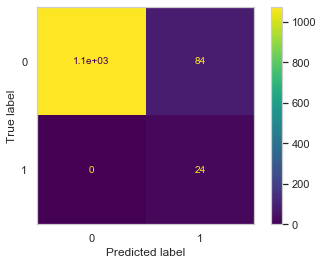

In [22]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

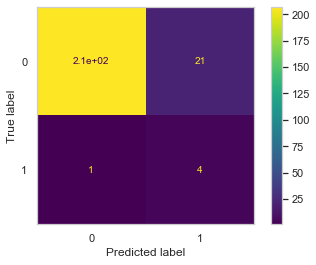

In [23]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [24]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.00021248, 0.00024752, 0.00025532, 0.00032492, 0.0003849 ])

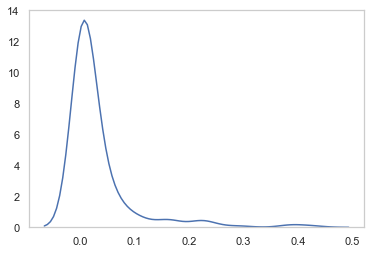

In [25]:
sns.kdeplot(y_pred);

In [26]:
metrics.confusion_matrix(y_test, y_pred > 0.03)

array([[175,  53],
       [  0,   5]])

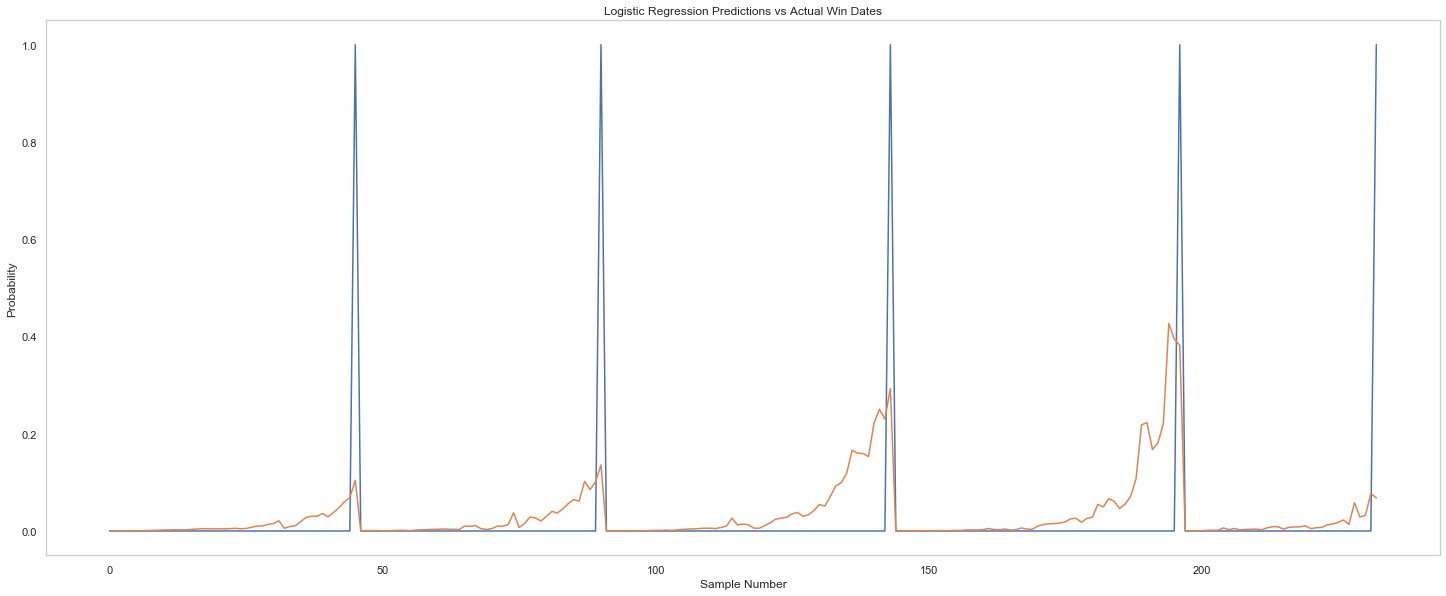

In [27]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

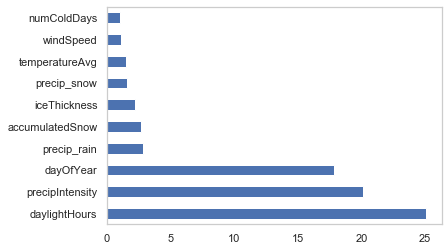

In [28]:
pd.Series(abs(clf_svc.coef_[0]), index=train[svc_no_ma_cols].columns).nlargest(10).plot(kind='barh');

In [29]:
svm_best_cols = ['daylightHours', 'precipIntensity', 'dayOfYear', 'temperatureAvg', 'accumulatedSnow', 'iceThickness', 'numColdDays']

---
#### Support Vector Machine Classifier Model Using Top Features From Baseline Excluding Moving Average Features Model

In [30]:
target = 'winningDate'

scaler = RobustScaler()

clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)

pipe = make_pipeline(scaler, clf_svc)

X_train, y_train = train[svm_best_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# top features from baseline
# f1: 0.20469460563077585 +/- 0.02678913900592102
# f1_weighted: 0.9030605198811366 +/- 0.022859779955204374
# precision: 0.11598560354374307 +/- 0.017863503807538136
# precision_weighted: 0.9801216865649639 +/- 0.0021621715559969573
# recall: 0.9099999999999999 +/- 0.11135528725660043
# recall_weighted: 0.8512837016377028 +/- 0.03688788048573668
# accuracy: 0.8512837016377028 +/- 0.03688788048573668
# roc_auc: 0.9427330571727124 +/- 0.015846638216895473

f1: 0.20469460563077585 +/- 0.02678913900592102
f1_weighted: 0.9030605198811366 +/- 0.022859779955204374
precision: 0.11598560354374307 +/- 0.017863503807538136
precision_weighted: 0.9801216865649639 +/- 0.0021621715559969573
recall: 0.9099999999999999 +/- 0.11135528725660043
recall_weighted: 0.8512837016377028 +/- 0.03688788048573668
accuracy: 0.8512837016377028 +/- 0.03688788048573668
roc_auc: 0.9427330571727124 +/- 0.015846638216895473


In [31]:
pipe.fit(X_train, y_train)
X_test = test[svm_best_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [32]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.8454935622317596
Test set balanced_accuracy: 0.8232456140350877


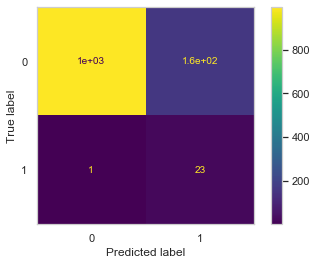

In [34]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

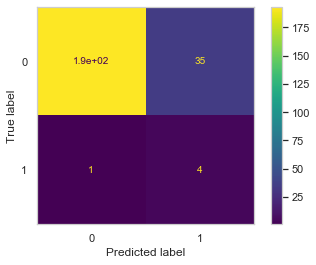

In [35]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [36]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([3.19157925e-07, 2.67264383e-07, 3.16342511e-07, 4.49894781e-07,
       6.55100704e-07])

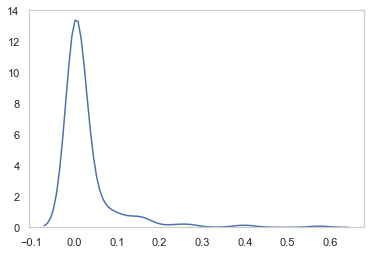

In [37]:
sns.kdeplot(y_pred);

In [38]:
metrics.confusion_matrix(y_test, y_pred > 1e-2)

array([[152,  76],
       [  0,   5]])

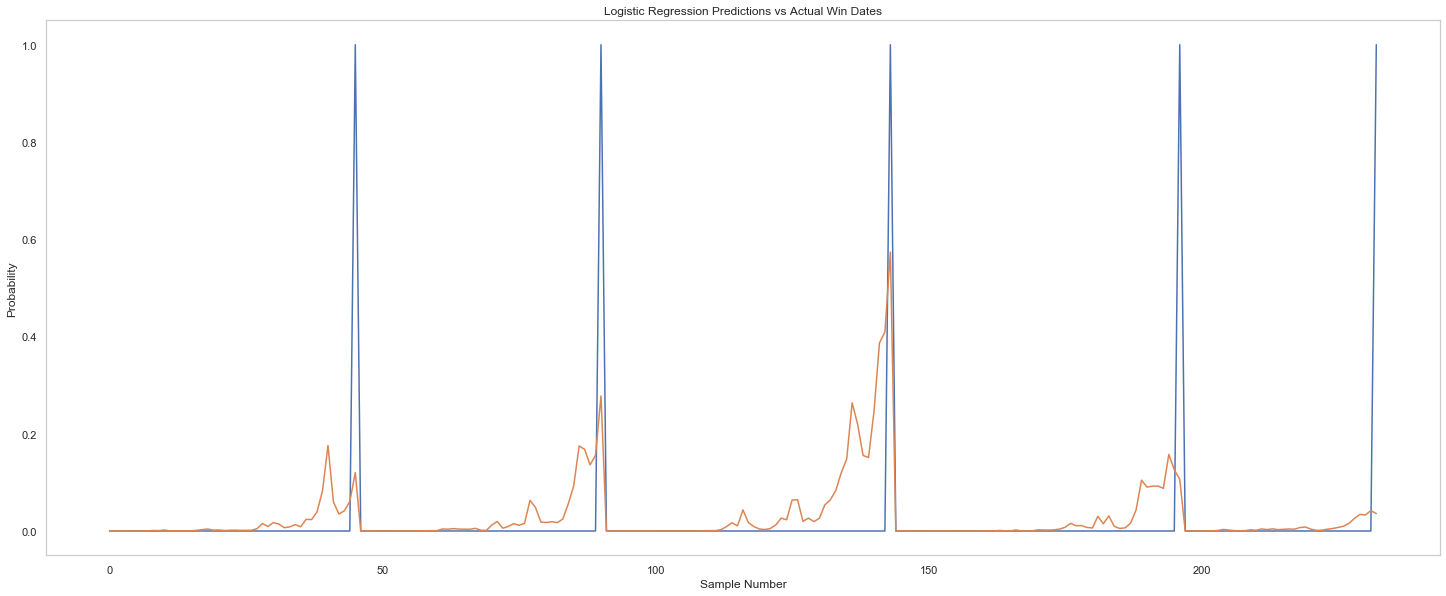

In [39]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Removed all models using moving average features
They were too resource-intensive for my laptop, and the base features the moving averages were derived from were enough for reasonably adequate performance.